# In_built Method


Source: https://langchain-ai.github.io/langgraph/how-tos/human_in_the_loop/breakpoints/

Breakpoints are a common HIL interaction pattern, allowing the graph to stop at specific steps and seek human approval before proceeding.

Breakpoints are built on top of LangGraph checkpoints, which save the graph's state after each node execution.

Checkpoints are saved in threads that preserve graph state and can be accessed after a graph has finished execution.

Benefits:

- Graph execution to pause at specific points
- Await human approval
- Resume execution from the last checkpoint.

In [1]:
print("Running script...")

Running script...


In [2]:
from typing import TypedDict, Annotated, Sequence
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver
from IPython.display import Image, display
from langgraph.graph.message import add_messages
import operator



class State(TypedDict):
    messages: Annotated[list, operator.add]

In [3]:
def function_1(state):
    return {'messages' :  [" First Function "]}

def function_2(state):
    return {'messages' : [" 2nd Function "]}

def function_3(state):
    return {'messages' : [" 3rd Function "]}

In [4]:

graph = StateGraph(State)
graph.add_node("step_1", function_1)
graph.add_node("step_2", function_2)
graph.add_node("step_3", function_3)
graph.add_edge(START, "step_1")
graph.add_edge("step_1", "step_2")
graph.add_edge("step_2", "step_3")
graph.add_edge("step_3", END)

# Set up memory
memory = MemorySaver()

# Add
graph = graph.compile(checkpointer=memory, interrupt_before=["step_3"])  # Interrupt before step_3

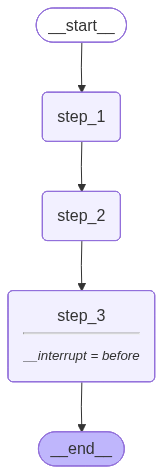

In [5]:
# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [6]:
# Input
initial_input = {"messages": ["hello langgraph"]}

# Thread
thread = {"configurable": {"thread_id": "1"}}

In [7]:
print(graph.invoke(initial_input, thread))

{'messages': ['hello langgraph', ' First Function ', ' 2nd Function ']}


In [ ]:
# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="values"):
    print(event)

{'messages': ['hello langgraph', ' First Function ', ' 2nd Function ', 'hello langgraph']}
{'messages': ['hello langgraph', ' First Function ', ' 2nd Function ', 'hello langgraph', ' First Function ']}
{'messages': ['hello langgraph', ' First Function ', ' 2nd Function ', 'hello langgraph', ' First Function ', ' 2nd Function ']}


In [9]:
snapshot = graph.get_state(thread)
snapshot.next

('step_3',)

In [10]:
thread = {"configurable": {"thread_id": "1"}}

for event in graph.stream(None, thread, stream_mode="values"):
        print(event)
     

{'messages': ['hello langgraph', ' First Function ', ' 2nd Function ', 'hello langgraph', ' First Function ', ' 2nd Function ']}
{'messages': ['hello langgraph', ' First Function ', ' 2nd Function ', 'hello langgraph', ' First Function ', ' 2nd Function ', ' 3rd Function ']}


In [11]:
snapshot = graph.get_state(thread)
snapshot.next

()

In [12]:
snapshot

StateSnapshot(values={'messages': ['hello langgraph', ' First Function ', ' 2nd Function ', 'hello langgraph', ' First Function ', ' 2nd Function ', ' 3rd Function ']}, next=(), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0b7a5f-6742-65cd-8007-3ea570bc9992'}}, metadata={'source': 'loop', 'step': 7, 'parents': {}}, created_at='2025-11-02T04:39:48.077921+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0b7a5e-588e-6d4f-8006-45687dfde346'}}, tasks=(), interrupts=())

In [ ]:
thread = {"configurable": {"thread_id": "11"}}       # Thread ID changed to 11

for event in graph.stream(None, thread, stream_mode="values"):
        print(event)

EmptyInputError: Received no input for __start__

### CheckwithPoint + Breakpoint with Toolcalling

In [ ]:
%pip install langgraph-checkpoint-sqlite --q

In [15]:
class State(TypedDict):
    messages: Annotated[list, add_messages]

In [16]:
import os
from dotenv import load_dotenv
load_dotenv()
from langchain_groq import ChatGroq
groq_api_key=os.getenv("GROQ_API_KEY")
model = ChatGroq(groq_api_key=groq_api_key,model_name="llama-3.1-8b-instant")

In [ ]:
from langchain_community.tools.tavily_search import TavilySearchResults
from typing_extensions import TypedDict

# from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

# Set up memory
memory = MemorySaver()

graph = StateGraph(State)

tool = TavilySearchResults(max_results=2)
tools = [tool]
llm_with_tools = model.bind_tools(tools)

C:\Users\hp\AppData\Local\Temp\ipykernel_17192\3255425057.py:15: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the `langchain-tavily package and should be used instead. To use it run `pip install -U `langchain-tavily` and import as `from `langchain_tavily import TavilySearch``.
  tool = TavilySearchResults(max_results=2)


In [18]:
llm_with_tools.invoke('what is langgraph?')

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'grm06953k', 'function': {'arguments': '{"query":"langgraph"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 19, 'prompt_tokens': 283, 'total_tokens': 302, 'completion_time': 0.028061843, 'prompt_time': 0.015606421, 'queue_time': 0.051961019, 'total_time': 0.043668264}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_33e8adf159', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--e6c0b3a4-212f-4d59-83dd-669b80fadc41-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'langgraph'}, 'id': 'grm06953k', 'type': 'tool_call'}], usage_metadata={'input_tokens': 283, 'output_tokens': 19, 'total_tokens': 302})

In [19]:
llm_with_tools.invoke('Hi')

AIMessage(content="I'm happy to help you with any questions or tasks you may have. Is there something specific you need assistance with or would you like to use the search engine to find information on a particular topic?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 41, 'prompt_tokens': 279, 'total_tokens': 320, 'completion_time': 0.070594423, 'prompt_time': 0.015261037, 'queue_time': 0.049245043, 'total_time': 0.08585546}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_ab04adca7d', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--20d196ed-09cf-4eb4-9197-3493107a39e6-0', usage_metadata={'input_tokens': 279, 'output_tokens': 41, 'total_tokens': 320})

In [20]:
def Agent(state: State):
    print('---> Starting Agent----->')
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

tool_node = ToolNode(tools=[tool])

In [21]:
graph.add_node("Agent", Agent)
graph.add_node("tools", tool_node)

graph.add_conditional_edges(
    "Agent",
    tools_condition,
)
graph.add_edge("tools", "Agent")
graph.set_entry_point("Agent")


In [ ]:
app = graph.compile(checkpointer=memory,interrupt_before=["tools"])

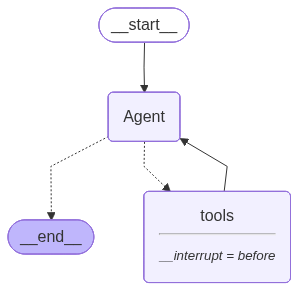

In [23]:
# View
display(Image(app.get_graph().draw_mermaid_png()))

In [24]:
from langchain_core.messages import HumanMessage
# Input
input_message = {'messages':HumanMessage(content="Hello, I am Mir , from Anantnag")}

# Thread
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in app.stream(input_message, thread, stream_mode="values"):
    print(event["messages"][-1].pretty_print())

================================ Human Message =================================

Hello, I am Mir , from Anantnag
None
---> Starting Agent----->
================================== Ai Message ==================================

Nice to meet you, Mir! Anantnag is a beautiful place in Jammu and Kashmir. What brings you here today? Would you like to talk about something specific or just have a casual conversation?
None


In [ ]:
# Input
input_message = {'messages':HumanMessage(content="What is the weather there?")}

# Thread
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in app.stream(input_message, thread, stream_mode="values"):
    print(event["messages"][-1].pretty_print())

================================ Human Message =================================

What is there weather there?
None
---> Starting Agent----->
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (x2ety4894)
 Call ID: x2ety4894
  Args:
    query: Anantnag weather
None


In [ ]:
# Run the graph until the first interruption
for event in app.stream(None, thread, stream_mode="values"):
    print(event["messages"][-1].pretty_print()) 

================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (x2ety4894)
 Call ID: x2ety4894
  Args:
    query: Anantnag weather
None
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "Anantnag, Jammu and Kashmir, India Monthly Weather - AccuWeather", "url": "https://www.accuweather.com/en/in/anantnag/359159/november-weather/359159", "content": "# Anantnag, Jammu and Kashmir\n\nAnantnag\n\nJammu and Kashmir\n\n## Around the Globe\n\nAround the Globe\n\n### Hurricane Tracker\n\n### Severe Weather\n\n### Radar & Maps\n\n### News & Features\n\n### Astronomy\n\n### Business\n\n### Climate\n\n### Health\n\n### Recreation\n\n### Sports\n\n### Travel\n\n### Warnings\n\n### Data Suite\n\n### Forensics\n\n### Advertising\n\n### Superior Accuracy™\n\n### Video\n\n## Monthly\n\n## November\n\n## 2025\n\n## Daily\n\n## Temperature Graph\n\n## Further Ahead\n\nFur

In [27]:
# Input
input_message = {'messages':HumanMessage(content="What are the best foods to explore there?")}

# Run the graph until the first interruption
for event in app.stream(input_message, thread, stream_mode="values"):
    print(event["messages"][-1].pretty_print())

================================ Human Message =================================

What are the best foods to explore there?
None
---> Starting Agent----->
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (n1wfzfh2f)
 Call ID: n1wfzfh2f
  Args:
    query: best foods in Anantnag Jammu and Kashmir
None


In [28]:
# Run the graph until the first interruption
for event in app.stream(None, thread, stream_mode="values"):
    print(event["messages"][-1].pretty_print())

================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (n1wfzfh2f)
 Call ID: n1wfzfh2f
  Args:
    query: best foods in Anantnag Jammu and Kashmir
None
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "Discover 7 Irresistible Street Foods In Pahalgam, Jammu & Kashmir", "url": "https://petuz.india.com/dishes/food-recipe/discover-7-irresistible-street-foods-in-pahalgam-jammu-kashmir-7328129/", "content": "Pahalgam is known for its lovely landscapes, beautiful vegetation and calm rivers. It is a small town in the Anantnag district of Jammu & Kashmir. It is located in the Indian Himalayas and is not only a nature lover's paradise but also a foodie's heaven. Street food in Pahalgam provides an opportunity to explore this rich culture through gastronomy with a myriad of traditions. Here are seven must-try street foods that capture the essence of Paha


snapshot = app.get_state(thread)
current_message = snapshot.values["messages"][-1]
current_message.pretty_print()

In [33]:
# Input
input_message = {'messages':HumanMessage(content="Tell me about the recent changes happening there?")}

# Run the graph until the first interruption
for event in app.stream(input_message, thread, stream_mode="values"):
    print(event["messages"][-1].pretty_print())

================================ Human Message =================================

Tell me about the recent changes happening there?
None
---> Starting Agent----->
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (cfxd4npb7)
 Call ID: cfxd4npb7
  Args:
    query: recent changes in Anantnag Jammu and Kashmir
None


In [35]:
snapshot = app.get_state(thread)
print(snapshot)
current_message = snapshot.values["messages"][-1]
current_message

StateSnapshot(values={'messages': [HumanMessage(content='Hello, I am Mir , from Anantnag', additional_kwargs={}, response_metadata={}, id='7741b432-50a3-4d7d-bc08-33e1a4ea0a15'), AIMessage(content='Nice to meet you, Mir! Anantnag is a beautiful place in Jammu and Kashmir. What brings you here today? Would you like to talk about something specific or just have a casual conversation?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 43, 'prompt_tokens': 289, 'total_tokens': 332, 'completion_time': 0.056004691, 'prompt_time': 0.015864239, 'queue_time': 0.049311011, 'total_time': 0.07186893}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_ab04adca7d', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--059d1e71-adcc-44e9-a85f-14f94541bf00-0', usage_metadata={'input_tokens': 289, 'output_tokens': 43, 'total_tokens': 332}), HumanMessage(content='What is there weather there?', additional_

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'cfxd4npb7', 'function': {'arguments': '{"query":"recent changes in Anantnag Jammu and Kashmir"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 28, 'prompt_tokens': 2324, 'total_tokens': 2352, 'completion_time': 0.025604886, 'prompt_time': 0.131294929, 'queue_time': 0.053446331, 'total_time': 0.156899815}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_ab04adca7d', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--708f0863-182a-494b-8b86-736ebf3e6a98-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'recent changes in Anantnag Jammu and Kashmir'}, 'id': 'cfxd4npb7', 'type': 'tool_call'}], usage_metadata={'input_tokens': 2324, 'output_tokens': 28, 'total_tokens': 2352})

In [39]:
tool_call_id = current_message. additional_kwargs['tool_calls'][0]['id']
tool_call_id

'cfxd4npb7'

In [40]:
from langchain_core.messages import AIMessage, ToolMessage

answer = """The recent changes in anantg are focused on infrastructure development, tourism promotion, and enhancing local culture awareness. The government is investing in better roads, hotels, and facilities to attract more visitors to the region. Additionally, there are initiatives to preserve the natural beauty and cultural heritage of Anantnag while promoting sustainable tourism practices."""
new_messages = [
    ToolMessage(content=answer, tool_call_id=tool_call_id),
    AIMessage(content=answer),
]

In [43]:
app.get_state(config= thread)

StateSnapshot(values={'messages': [HumanMessage(content='Hello, I am Mir , from Anantnag', additional_kwargs={}, response_metadata={}, id='7741b432-50a3-4d7d-bc08-33e1a4ea0a15'), AIMessage(content='Nice to meet you, Mir! Anantnag is a beautiful place in Jammu and Kashmir. What brings you here today? Would you like to talk about something specific or just have a casual conversation?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 43, 'prompt_tokens': 289, 'total_tokens': 332, 'completion_time': 0.056004691, 'prompt_time': 0.015864239, 'queue_time': 0.049311011, 'total_time': 0.07186893}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_ab04adca7d', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--059d1e71-adcc-44e9-a85f-14f94541bf00-0', usage_metadata={'input_tokens': 289, 'output_tokens': 43, 'total_tokens': 332}), HumanMessage(content='What is there weather there?', additional_

In [45]:
for i in app.get_state_history(config= thread):
    print(i)

StateSnapshot(values={'messages': [HumanMessage(content='Hello, I am Mir , from Anantnag', additional_kwargs={}, response_metadata={}, id='7741b432-50a3-4d7d-bc08-33e1a4ea0a15'), AIMessage(content='Nice to meet you, Mir! Anantnag is a beautiful place in Jammu and Kashmir. What brings you here today? Would you like to talk about something specific or just have a casual conversation?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 43, 'prompt_tokens': 289, 'total_tokens': 332, 'completion_time': 0.056004691, 'prompt_time': 0.015864239, 'queue_time': 0.049311011, 'total_time': 0.07186893}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_ab04adca7d', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--059d1e71-adcc-44e9-a85f-14f94541bf00-0', usage_metadata={'input_tokens': 289, 'output_tokens': 43, 'total_tokens': 332}), HumanMessage(content='What is there weather there?', additional_

In [46]:
app.update_state(
    thread,
    {"messages": new_messages},
)

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0b7a9d-1ad5-6279-8015-2fb4fedb28b3'}}

In [47]:
for i in app.get_state_history(config= thread):
    print(i)
    

StateSnapshot(values={'messages': [HumanMessage(content='Hello, I am Mir , from Anantnag', additional_kwargs={}, response_metadata={}, id='7741b432-50a3-4d7d-bc08-33e1a4ea0a15'), AIMessage(content='Nice to meet you, Mir! Anantnag is a beautiful place in Jammu and Kashmir. What brings you here today? Would you like to talk about something specific or just have a casual conversation?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 43, 'prompt_tokens': 289, 'total_tokens': 332, 'completion_time': 0.056004691, 'prompt_time': 0.015864239, 'queue_time': 0.049311011, 'total_time': 0.07186893}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_ab04adca7d', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--059d1e71-adcc-44e9-a85f-14f94541bf00-0', usage_metadata={'input_tokens': 289, 'output_tokens': 43, 'total_tokens': 332}), HumanMessage(content='What is there weather there?', additional_

In [48]:
print(app.get_state(thread).values["messages"][-1:])

[AIMessage(content='The recent changes in anantg are focused on infrastructure development, tourism promotion, and enhancing local culture awareness. The government is investing in better roads, hotels, and facilities to attract more visitors to the region. Additionally, there are initiatives to preserve the natural beauty and cultural heritage of Anantnag while promoting sustainable tourism practices.', additional_kwargs={}, response_metadata={}, id='6b07e23e-7e17-442d-942a-4c7c14ae3beb')]
